punkt ✅ found
stopwords ✅ found
vader_lexicon ✅ found


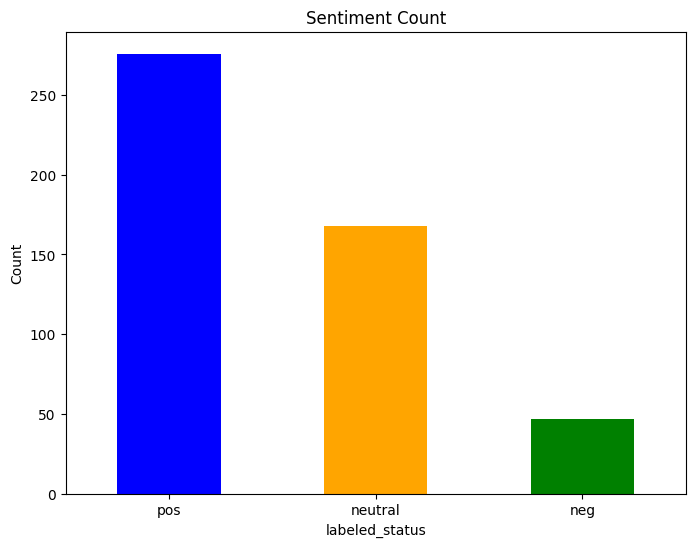

✅ Preprocessed data saved to kosis_preprocessed.csv

Decision Tree Accuracy: 0.62
              precision    recall  f1-score   support

         neg       0.29      0.46      0.35        13
     neutral       0.45      0.44      0.45        34
         pos       0.89      0.77      0.82        52

    accuracy                           0.62        99
   macro avg       0.54      0.56      0.54        99
weighted avg       0.66      0.62      0.63        99


Random Forest Accuracy: 0.75
              precision    recall  f1-score   support

         neg       0.39      0.54      0.45        13
     neutral       0.63      0.65      0.64        34
         pos       0.98      0.87      0.92        52

    accuracy                           0.75        99
   macro avg       0.67      0.68      0.67        99
weighted avg       0.78      0.75      0.76        99


Decision Tree - Top 10 Important Features:
              feature  importance
1001  compound_score    0.315970
1003  negative_

In [37]:
import os
import pandas as pd
import numpy as np
import nltk

# Set NLTK data path
nltk_data_path = r"C:\Users\ayush\OneDrive\Desktop\Meachine_learning\Deployment\Streamlit_Web_App\final\nltk_data"
if nltk_data_path not in nltk.data.path:
    nltk.data.path.append(nltk_data_path)

# Ensure required NLTK resources
for resource in ['punkt', 'stopwords', 'vader_lexicon']:
    try:
        nltk.data.find(f'corpora/{resource}' if resource == 'stopwords' else f'tokenizers/{resource}' if resource == 'punkt' else f'sentiment/{resource}')
        print(f"{resource} ✅ found")
    except LookupError:
        print(f"{resource} ❌ not found, downloading...")
        nltk.download(resource, download_dir=nltk_data_path)

# Now import required modules
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from imblearn.over_sampling import SMOTE
from wordcloud import WordCloud
import matplotlib.pyplot as plt


# === Functions ===

def analyze_sentiment(text):
    sid = SentimentIntensityAnalyzer()
    return sid.polarity_scores(text)


def remove_stopwords_and_get_unique(text):
    if pd.isna(text) or not isinstance(text, str):
        return []
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text.lower())
    return list(set(word for word in tokens if word.isalnum() and word not in stop_words))


# Load dataset
df = pd.read_csv("train_data.csv")
df['text'] = df['text'].fillna("").astype(str)
df['unique_tokens'] = df['text'].apply(remove_stopwords_and_get_unique)
df['token_count'] = df['unique_tokens'].apply(len)

# Sentiment analysis
df['sentiment_scores'] = df['text'].apply(analyze_sentiment)
df['compound_score'] = df['sentiment_scores'].apply(lambda x: x['compound'])
df['positive_score'] = df['sentiment_scores'].apply(lambda x: x['pos'])
df['negative_score'] = df['sentiment_scores'].apply(lambda x: x['neg'])
df['neutral_score'] = df['sentiment_scores'].apply(lambda x: x['neu'])

# Visualization
df['labeled_status'].value_counts().plot(kind='bar', figsize=(8, 6), color=['blue', 'orange', 'green'])
plt.title("Sentiment Count")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()

# Word cloud
all_tokens = df['unique_tokens'].explode().dropna().tolist()
WordCloud(width=800, height=600).generate(" ".join(all_tokens)).to_image().show()

# Drop unused column
df.drop("sentiment_scores", axis=1, inplace=True)
df.to_csv("kosis_preprocessed.csv", index=False)
print("✅ Preprocessed data saved to kosis_preprocessed.csv")

# Feature engineering
vectorizer = CountVectorizer(max_features=1000)
token_features = vectorizer.fit_transform(df['unique_tokens'].apply(lambda x: ' '.join(x)))

X = pd.concat([
    pd.DataFrame(token_features.toarray(), columns=vectorizer.get_feature_names_out()),
    df[['token_count', 'compound_score', 'positive_score', 'negative_score', 'neutral_score']]
], axis=1)

y = df['labeled_status']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE
X_res, y_res = SMOTE(random_state=42).fit_resample(X_train, y_train)

# Train models
dt_model = DecisionTreeClassifier(random_state=42).fit(X_res, y_res)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42).fit(X_res, y_res)

import joblib

joblib.dump(dt_model, "model_dt.pkl")
joblib.dump(rf_model, "model_rf.pkl")
joblib.dump(vectorizer, "vectorizer.pkl")

# Evaluate
for model, name in zip([dt_model, rf_model], ["Decision Tree", "Random Forest"]):
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    print(f"\n{name} Accuracy: {acc:.2f}")
    print(classification_report(y_test, preds))

# Feature importance
for model, name in zip([dt_model, rf_model], ["Decision Tree", "Random Forest"]):
    feat_imp = pd.DataFrame({
        'feature': X.columns,
        'importance': model.feature_importances_
    }).sort_values("importance", ascending=False)
    print(f"\n{name} - Top 10 Important Features:\n", feat_imp.head(10))


# === Prediction on new sentence (without POS tagging) ===

def preprocess_single_sentence(sentence):
    tokens = remove_stopwords_and_get_unique(sentence)
    sentiment_scores = analyze_sentiment(sentence)

    token_feats = vectorizer.transform([' '.join(tokens)])

    features = pd.concat([
        pd.DataFrame(token_feats.toarray(), columns=vectorizer.get_feature_names_out()),
        pd.DataFrame([[len(tokens), sentiment_scores['compound'], sentiment_scores['pos'],
                       sentiment_scores['neg'], sentiment_scores['neu']]],
                     columns=['token_count', 'compound_score', 'positive_score', 'negative_score', 'neutral_score'])
    ], axis=1)

    return features


def categorize_sentence(sentence, model):
    return model.predict(preprocess_single_sentence(sentence))[0]


# Example usage
test_sentence = "This is the most worst and bad part of the video."
print("\nTest sentence:", test_sentence)
print("Decision Tree Prediction:", categorize_sentence(test_sentence, dt_model))
print("Random Forest Prediction:", categorize_sentence(test_sentence, rf_model))


In [38]:
df.columns


Index(['Unnamed: 0', 'id', 'author', 'published_at', 'updated_at',
       'like_count', 'sentiment_score', 'text', 'labeled_status',
       'unique_tokens', 'token_count', 'compound_score', 'positive_score',
       'negative_score', 'neutral_score'],
      dtype='object')

In [39]:
df.columns


Index(['Unnamed: 0', 'id', 'author', 'published_at', 'updated_at',
       'like_count', 'sentiment_score', 'text', 'labeled_status',
       'unique_tokens', 'token_count', 'compound_score', 'positive_score',
       'negative_score', 'neutral_score'],
      dtype='object')

In [40]:
df.columns


Index(['Unnamed: 0', 'id', 'author', 'published_at', 'updated_at',
       'like_count', 'sentiment_score', 'text', 'labeled_status',
       'unique_tokens', 'token_count', 'compound_score', 'positive_score',
       'negative_score', 'neutral_score'],
      dtype='object')

In [41]:
df.columns


Index(['Unnamed: 0', 'id', 'author', 'published_at', 'updated_at',
       'like_count', 'sentiment_score', 'text', 'labeled_status',
       'unique_tokens', 'token_count', 'compound_score', 'positive_score',
       'negative_score', 'neutral_score'],
      dtype='object')

In [42]:
df.columns


Index(['Unnamed: 0', 'id', 'author', 'published_at', 'updated_at',
       'like_count', 'sentiment_score', 'text', 'labeled_status',
       'unique_tokens', 'token_count', 'compound_score', 'positive_score',
       'negative_score', 'neutral_score'],
      dtype='object')

In [43]:
df.columns


Index(['Unnamed: 0', 'id', 'author', 'published_at', 'updated_at',
       'like_count', 'sentiment_score', 'text', 'labeled_status',
       'unique_tokens', 'token_count', 'compound_score', 'positive_score',
       'negative_score', 'neutral_score'],
      dtype='object')

In [44]:
df.columns


Index(['Unnamed: 0', 'id', 'author', 'published_at', 'updated_at',
       'like_count', 'sentiment_score', 'text', 'labeled_status',
       'unique_tokens', 'token_count', 'compound_score', 'positive_score',
       'negative_score', 'neutral_score'],
      dtype='object')

In [45]:
df.columns


Index(['Unnamed: 0', 'id', 'author', 'published_at', 'updated_at',
       'like_count', 'sentiment_score', 'text', 'labeled_status',
       'unique_tokens', 'token_count', 'compound_score', 'positive_score',
       'negative_score', 'neutral_score'],
      dtype='object')